<a href="https://colab.research.google.com/github/QuickIsaac/Black-Litterman/blob/main/APT%26Black_Litterman_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyPortfolioOpt

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
from sklearn.linear_model import LinearRegression
from collections import defaultdict

# Arbitrage Pricing Theory(APT)
- This section aims to create a covariance matrix based on a regression model, to incorporate the underlying relationship between macroeconomic factors and assets

In [ ]:
# -------------------------------
# 1) Download & Prepare Asset Data
# -------------------------------
tickers = "NVDA GS C ICLN ECBI.F KC=F INDA RDY LIT FXI"
df_assets = yf.download(tickers=tickers, start="2014-01-01", end="2024-01-01", interval="1d")
df_assets = df_assets["Close"].resample("QE").last()  # Use quarterly frequency
asset_returns_df = df_assets.pct_change().dropna()

[*********************100%***********************]  10 of 10 completed
<ipython-input-3-4df1bb67752f>:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  asset_returns_df = df_assets.pct_change().dropna()


In [ ]:
# -------------------------------
# 2) Download & Prepare Macro Factors Data
# -------------------------------
# Data must be in google drive specific location
from google.colab import drive
drive.mount("/content/drive")

date1 = "2014-01-01"
date2 = "2024-01-01"
factors = {
    "URATEUS": "/content/drive/My Drive/EconDB/URATEUS.csv",
    "CPIUK": "/content/drive/My Drive/EconDB/CPIUK.csv",
    "RGDPIN": "/content/drive/My Drive/EconDB/RGDPIN.csv",
    "GSPECN": "/content/drive/My Drive/EconDB/GSPECN.csv",
    "RETACN": "/content/drive/My Drive/EconDB/RETACN.csv",
}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#2) Data resampling to quarters
def manual_resample_to_quarterly(df):
    """Manual quarter labeling + average per quarter."""
    quarterly_data = []
    for _, row in df.iterrows():
        y, m = row["Date"].year, row["Date"].month
        if m in [1, 2, 3]:
            q = f"{y}-Q1"
        elif m in [4, 5, 6]:
            q = f"{y}-Q2"
        elif m in [7, 8, 9]:
            q = f"{y}-Q3"
        else:
            q = f"{y}-Q4"
        quarterly_data.append((q, row[1]))

    # Aggregate by quarter
    temp = defaultdict(list)
    for q, val in quarterly_data:
        temp[q].append(val)
    result = {q: np.mean(vals) for q, vals in temp.items()}
    return result

# Read, rename columns, and store quarterly factor data
data_resampled = {}
for name, filepath in factors.items():
    df_f = pd.read_csv(filepath)
    df_f.columns = ["Date", name]
    df_f["Date"] = pd.to_datetime(df_f["Date"])
    data_resampled[name] = manual_resample_to_quarterly(df_f)

# Combine factor data into final DataFrame
combined_data = defaultdict(dict)
for factor_name, qdict in data_resampled.items():
    for quarter, val in qdict.items():
        combined_data[quarter][factor_name] = val

final_df = pd.DataFrame.from_dict(combined_data, orient="index").sort_index()
final_df.index = pd.PeriodIndex(final_df.index, freq="Q")
final_df = final_df[(final_df.index >= date1) & (final_df.index <= date2)]
factors_returns_df = final_df.pct_change().dropna()

<ipython-input-5-cf48e0bb7a2e>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quarterly_data.append((q, row[1]))
<ipython-input-5-cf48e0bb7a2e>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quarterly_data.append((q, row[1]))
<ipython-input-5-cf48e0bb7a2e>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quarterly_data.append((q, row[1]))
<ipython-input-5-cf48e0bb7a2e>:15: FutureWarning: Series.__getitem__ treating keys as po

In [ ]:
#3) Align Asset & Factor Returns

factors_returns_df.index = factors_returns_df.index.to_timestamp("Q", "end")
asset_returns_df.index = asset_returns_df.index.to_period("Q").to_timestamp("Q", "end")
common_index = factors_returns_df.index.intersection(asset_returns_df.index)

aligned_asset_returns = asset_returns_df.loc[common_index]
aligned_factors_returns = factors_returns_df.loc[common_index]

aligned_asset_matrix = aligned_asset_returns.values
aligned_factors_matrix = aligned_factors_returns.values

In [ ]:
# 4) APT: Factor Regression

n_assets = len(tickers.split())
n_factors = len(factors)

alphas, betas, residuals = [], [], []

for i in range(n_assets):
    lr = LinearRegression()
    lr.fit(aligned_factors_matrix, aligned_asset_matrix[:, i])
    alphas.append(lr.intercept_)
    betas.append(lr.coef_)
    predicted = lr.predict(aligned_factors_matrix)
    residuals.append(aligned_asset_matrix[:, i] - predicted)

idiosyncratic_variances = [np.var(r) for r in residuals]
B = np.array(betas)
Sigma_epsilon = np.diag(idiosyncratic_variances)
Sigma_F = np.cov(aligned_factors_matrix, rowvar=False)

# Covariance of assets via APT
covariance_matrix = B @ Sigma_F @ B.T + Sigma_epsilon
expected_factor_returns = np.mean(aligned_factors_matrix, axis=0)
expected_asset_returns_apt = np.array(alphas) + B @ expected_factor_returns

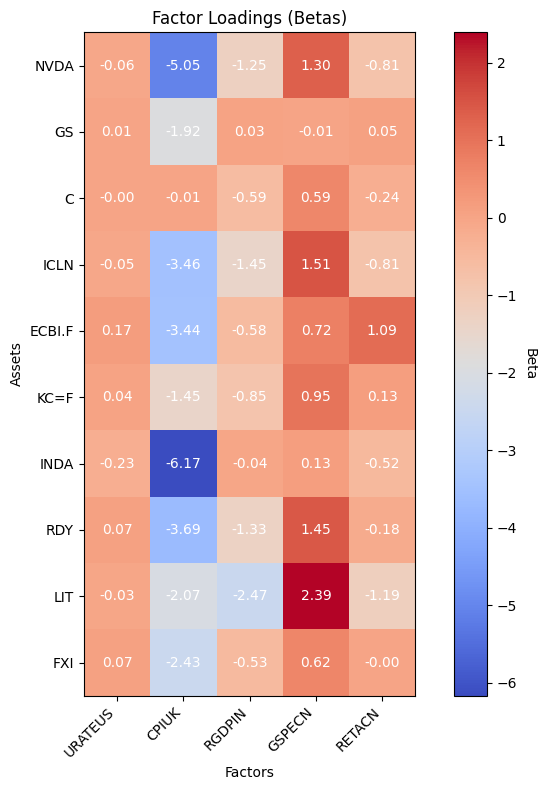

In [ ]:
# Create a DataFrame for the betas
betas_df = pd.DataFrame(B, index=tickers.split(), columns=list(factors.keys()))

# Assuming 'B', 'tickers', and 'factors' are already defined

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 8))

# Create the heatmap using imshow
im = ax.imshow(B, cmap='coolwarm', interpolation='nearest')

# Set the tick labels and rotation
ax.set_xticks(np.arange(len(factors)))
ax.set_yticks(np.arange(len(tickers.split())))
ax.set_xticklabels(list(factors.keys()), rotation=45, ha='right')
ax.set_yticklabels(tickers.split())

# Add annotations (beta values)
for i in range(len(tickers.split())):
    for j in range(len(factors)):
        text = ax.text(j, i, f"{B[i, j]:.2f}", ha="center", va="center", color="w")

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Beta", rotation=-90, va="bottom")

# Set the title and labels
ax.set_title('Factor Loadings (Betas)')
ax.set_xlabel('Factors')
ax.set_ylabel('Assets')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

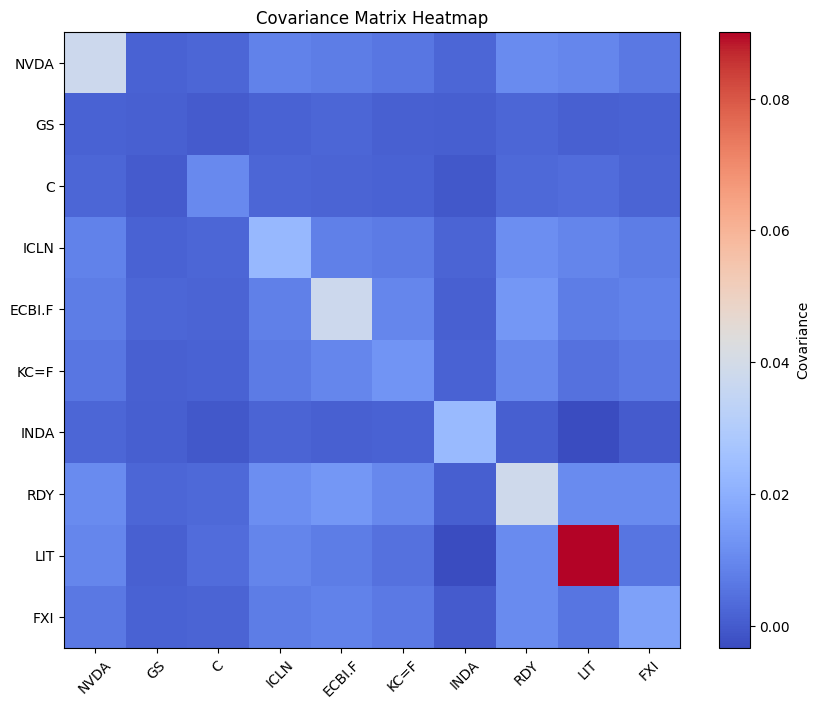

In [ ]:
# Visualization: Covariance Matrix
plt.figure(figsize=(10, 8))
plt.title("Covariance Matrix Heatmap")
plt.imshow(covariance_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Covariance")
plt.xticks(range(len(tickers.split())), tickers.split(), rotation=45)
plt.yticks(range(len(tickers.split())), tickers.split())
plt.show()

# 2. Black-Litterman Optimization

In [ ]:
# -------------------------------
# 1) Black-Litterman Inputs and Priors Calc.
# -------------------------------
assets_list = tickers.split()
cov_matrix = pd.DataFrame(covariance_matrix, index=assets_list, columns=assets_list)
# Hardcoded market caps, as yfinance does not offer direct route for certain assets
market_caps = {
    "NVDA": 3_373_000_000_000,
    "GS":   196_489_000_000,
    "C":    150_149_000_000,
    "ICLN": 1_420_000_000,
    "ECBI.F": 148_360_000,
    "KC=F": 116_000_000_000,
    "INDA": 10_000_000_000,
    "RDY": 1_673_940,
    "LIT":  1_090_000_000,
    "FXI":  7_270_000_000,
}

# Market-implied risk aversion parameter
spy_data = yf.download("SPY", start="2014-01-01", end="2024-01-01")["Close"]
risk_free_rate = 0.02
delta = black_litterman.market_implied_risk_aversion(spy_data, risk_free_rate=risk_free_rate)

# Market-implied prior returns
market_prior = black_litterman.market_implied_prior_returns(market_caps, delta, cov_matrix)

[*********************100%***********************]  1 of 1 completed


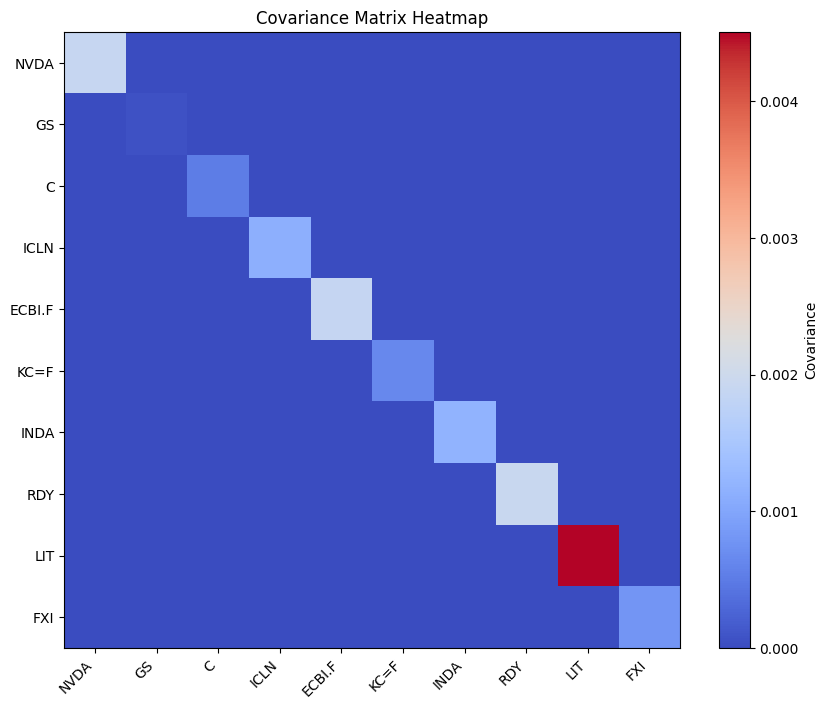

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Covariance Matrix Heatmap")
plt.imshow(bl.omega, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Covariance")  # Add colorbar with label
plt.xticks(range(len(bl.tickers)), bl.tickers, rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(range(len(bl.tickers)), bl.tickers)
plt.show()


In [ ]:
# -------------------------------
# 2) Views
# -------------------------------
# Absolute Views
absolute_views = {
    "NVDA": 0.18,
    "GS":   0.09,
    "C":    0.08,
    "ICLN": 0.11,
    "ECBI.F": 0.05,
    "KC=F": 0.13,
    "INDA": 0.07,
    "RDY": 0.06,
    "LIT":  0.08,
    "FXI":  0.09
}

bl = BlackLittermanModel(
    cov_matrix=cov_matrix,
    pi=market_prior,
    absolute_views=absolute_views
)

posterior_returns = bl.bl_returns()
posterior_cov = bl.bl_cov()

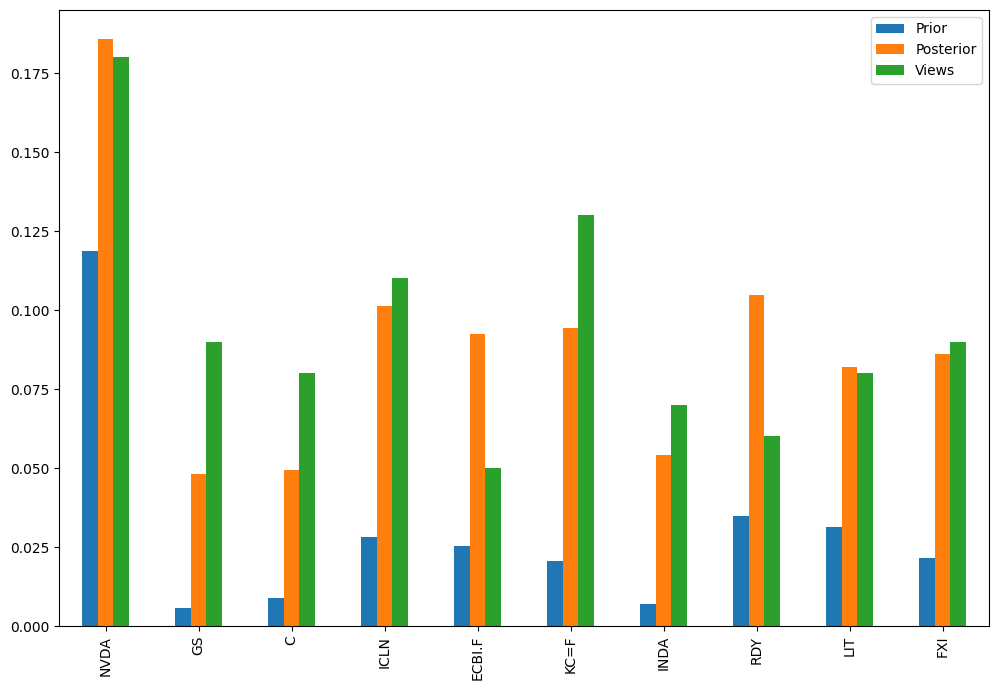

In [ ]:
rets_df = pd.DataFrame([market_prior, posterior_returns, pd.Series(absolute_views)],
             index=["Prior", "Posterior", "Views"]).T
rets_df.plot.bar(figsize=(12,8));

In [ ]:
# Define the range of target returns
min_return = min(posterior_returns)  # Minimum return from posterior
# Instead of using max(posterior_returns), calculate the maximum portfolio return
ef_temp = EfficientFrontier(posterior_returns, posterior_cov, weight_bounds=(0, 0.15))
max_return = ef_temp._max_return()  # Get the maximum achievable return
target_returns = np.linspace(min_return, max_return, 100)  # Generate target return range

risks = []  # To store portfolio risks (volatility)
returns = []  # To store portfolio returns

# Loop through target returns to compute corresponding risks
for target_return in target_returns:
    ef_temp = EfficientFrontier(posterior_returns, posterior_cov, weight_bounds=(0, 0.15))
    ef_temp.efficient_return(target_return)  # Optimize portfolio for the target return
    performance = ef_temp.portfolio_performance(verbose=False)
    risks.append(performance[1])  # Append risk (volatility)
    returns.append(performance[0])  # Append return

# Calculate Max Sharpe Portfolio Performance
ef = EfficientFrontier(posterior_returns, posterior_cov, weight_bounds=(0, 0.15))
weights = ef.max_sharpe()  # Find the weights for the Max Sharpe portfolio
max_sharpe_performance = ef.portfolio_performance(verbose=False)  # Performance metrics

performance = ef.portfolio_performance(verbose=True)

Expected annual return: 8.8%
Annual volatility: 7.0%
Sharpe Ratio: 1.25


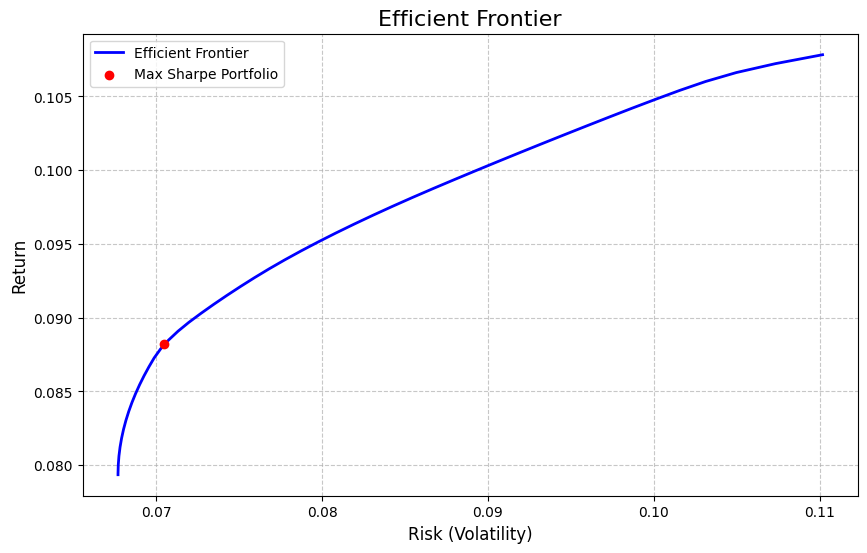

In [ ]:
# Plot the Efficient Frontier
plt.figure(figsize=(10, 6))
plt.plot(risks, returns, label="Efficient Frontier", color="blue", lw=2)  # Frontier curve
plt.scatter(max_sharpe_performance[1], max_sharpe_performance[0],  # Max Sharpe Portfolio
            color="red", label="Max Sharpe Portfolio", zorder=5)
plt.title("Efficient Frontier", fontsize=16)
plt.xlabel("Risk (Volatility)", fontsize=12)
plt.ylabel("Return", fontsize=12)
plt.legend(loc="best")
plt.grid(linestyle="--", alpha=0.7)
plt.show()



Optimized Portfolio Weights:
NVDA: 0.150
GS: 0.150
C: 0.150
ICLN: 0.089
ECBI.F: 0.016
KC=F: 0.150
INDA: 0.132
RDY: 0.000
LIT: 0.013
FXI: 0.150


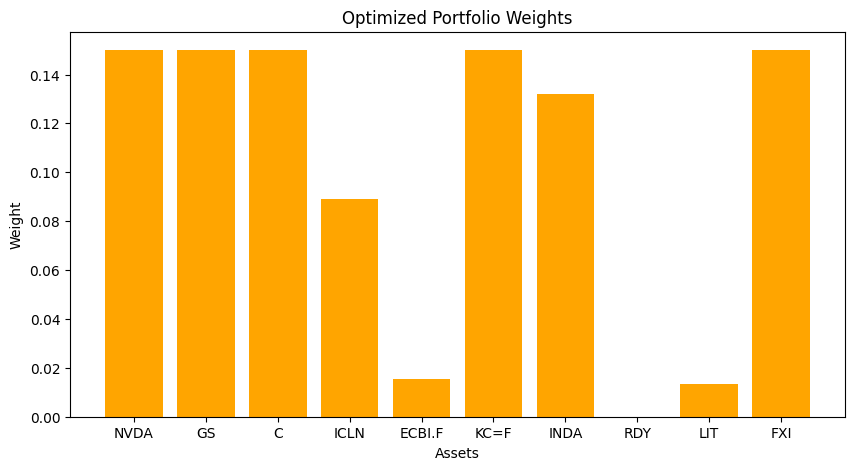

In [ ]:

print("\nOptimized Portfolio Weights:")
for asset, w in cleaned_weights.items():
    print(f"{asset}: {w:.3f}")

# Visualize
plt.figure(figsize=(10, 5))
plt.bar(cleaned_weights.keys(), cleaned_weights.values(), color="orange")
plt.title("Optimized Portfolio Weights")
plt.ylabel("Weight")
plt.xlabel("Assets")
plt.show()
